In [1]:
from torch import torch
from torch import Tensor
import matplotlib.pyplot as plt

In [10]:
from utils import join

In [2]:
# hprams loading 
from hydra import compose, initialize
from sys import argv
initialize(config_path="config")
hprams = compose(config_name="configs")
def get_melkwargs() -> dict:
    return {
        'n_fft': hprams.data.n_fft,
        'win_length': hprams.data.win_length,
        'hop_length': hprams.data.hop_length
    }


def get_snr_params() -> dict:
    return {
        'sample_rate': hprams.data.sampling_rate,
        'win_length': hprams.data.win_length,
        'hop_length': hprams.data.hop_length,
        'min_snr': hprams.data.min_snr,
        'max_snr': hprams.data.max_snr
    }

In [3]:
from torch.nn import Module
from data import (
    NoisedAudPipeline,
    AudioPipeline
    )
from utils import SNR, load_model, join

In [4]:
get_melkwargs()

{'n_fft': 400, 'win_length': 400, 'hop_length': 200}

In [5]:
class Predict:
    def __init__(
            self,
            noised_pipeline: NoisedAudPipeline,
            model: Module,
            device: str
            ) -> None:
        self.noised_pipeline = noised_pipeline
        self.model = model.to(device)
        self.device = device

    def predict(self, signal: Tensor):
        signal = self.noised_pipeline.run(signal)
        signal = signal.permute(0, 2, 1)
        return self.model(signal, torch.tensor([signal.shape[1]]))


def get_predictor() -> Predict:
    model = load_model(
        hprams.model, 
        hprams.checkpoint, 
        device=hprams.device
    )
    noised_pipeline = NoisedAudPipeline(
        hprams.data.sampling_rate,
        hprams.data.n_mfcc,
        get_melkwargs()
    )
    return Predict(
        noised_pipeline,
        model,
        hprams.device
    )

In [14]:
predictor = get_predictor()
aud_pipeline = AudioPipeline(hprams.data.sampling_rate)
noised_pipeline = NoisedAudPipeline(
        hprams.data.sampling_rate,
        hprams.data.n_mfcc,
        get_melkwargs()
)
snr_calc = SNR(**get_snr_params())

In [15]:
noise_path = 'samples/noise/constructionSite_bg21.wav'
audio_path = 'samples/audios/19-198-0005.flac'

In [16]:
signal = aud_pipeline.run(audio_path)

In [22]:
signal.shape

torch.Size([1, 230240])

In [23]:
signal = signal

In [37]:
noise = aud_pipeline.run(noise_path)
new_aud, noise = join(signal, noise, seed=42)

In [44]:
preds = predictor.predict(new_aud).squeeze()

In [25]:
import IPython

In [34]:
IPython.display.Audio(signal, rate=16000)

In [35]:
IPython.display.Audio(noise, rate=16000)

In [36]:
IPython.display.Audio(new_aud, rate=16000)

In [42]:
snr = snr_calc(signal, noise).squeeze()

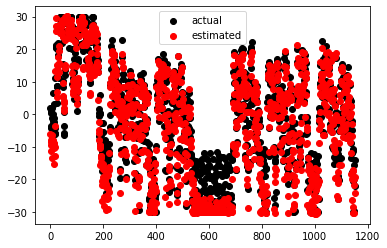

In [55]:
plt.scatter(range(snr.shape[0]), snr, color='black')
plt.scatter(range(snr.shape[0]), preds.detach(), color='red')
plt.legend(['actual', 'estimated'])

In [62]:
noise_path = 'samples/noise/crowd_bg06.wav'
audio_path = 'samples/audios/19-198-0034.flac'

In [63]:
signal = aud_pipeline.run(audio_path)

In [64]:
signal.shape

torch.Size([1, 266000])

In [76]:
signal = signal[:, :50000]

In [77]:
noise = aud_pipeline.run(noise_path)
new_aud, noise = join(signal, noise, seed=42)

In [78]:
preds = predictor.predict(new_aud).squeeze()

In [79]:
import IPython

In [80]:
IPython.display.Audio(signal, rate=16000)

In [81]:
IPython.display.Audio(noise, rate=16000)

In [82]:
IPython.display.Audio(new_aud, rate=16000)

In [83]:
snr = snr_calc(signal, noise).squeeze()

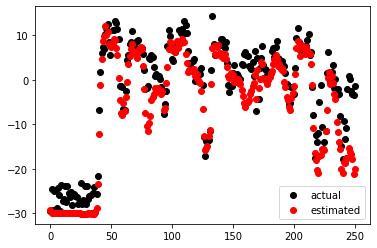

In [84]:
plt.scatter(range(snr.shape[0]), snr, color='black')
plt.scatter(range(snr.shape[0]), preds.detach(), color='red')
plt.legend(['actual', 'estimated'])